In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 28 22:42:37 2020

@author: pranaydogra
"""
import pandas as pd
import bokeh.plotting as bpl
import umap
import phenograph
import os
import gc
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import colors as mcolors
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from bokeh.plotting import figure, output_file, show
#from bokeh.palettes import d3
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

pd.set_option("max_columns", 30)
pd.set_option("max_rows", 50)

dir = "Enter path to directory where you have the term dataframes saved we generated previously"
save_dir = "Enter path to directory where you want to direct all the output"
os.chdir(dir)
print(os.getcwd())

In [2]:
# Enter keyword for which you need text clustering
keyword = 't cell'

# Cluster text based on entire text
for file in os.listdir():
    if keyword in file:
        term_df = pd.read_csv(file)
        term_df = term_df.dropna(subset = ["title"])
        print(keyword.upper())
        print("The dataframe has {} entries".format(term_df.shape[0]))
        #print(term_df.head())
        gc.collect()

# Vectorize the text
vectorizer = TfidfVectorizer(stop_words = "english", strip_accents = "ascii", max_features = 2**12)
X = vectorizer.fit_transform(tqdm(term_df["body_text"].values))
gc.collect()
print(X.shape)

  0%|          | 3/7513 [00:00<04:57, 25.23it/s]

T CELL
The dataframe has 7513 entries
                                   paper_id  \
0  b1ffbf88b407e4f859046c2106ef7b6b661b94d5   
1  cd78c92eee1fc0049e85e39229c8eca5b9334415   
3  cdd392633a8420a6a4dcd533949b4de54d0238aa   
4  69ae80f15e2b6e40a90752e801332926b62f6083   
5  5eea19cc62b0cb646dd64f28ce8067a0dc7fbd2e   

                                               title  \
0  inflammation induced by infection potentiates ...   
1  cxcl10ip-10 in infectious diseases pathogenesi...   
3  rhinosinusitis establishing definitions for cl...   
4  levels of complexity in pathogen recognition b...   
5                   fc receptors in immune responses   

                                            abstract  \
0  comorbidities that promote the progression of ...   
1  c-x-c motif chemokine 10 cxcl10 also known as ...   
3                                                NaN   
4  in pathogen recognition by c-type lectins seve...   
5                                                NaN   

     

100%|██████████| 7513/7513 [02:31<00:00, 49.49it/s]


(7513, 4096)


In [5]:
# Louvain clustering of text
communities, graph, Q = phenograph.cluster(X, k = 100)
num_lclusters = len(set(communities))
print("Louvain clustering classified the papers into {} clusters".format(num_lclusters))

#K-means clustering of text
k = num_lclusters # equate the number of clusters for both for easy comparison 
kmeans = MiniBatchKMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)
num_kclusters = len(set(y_pred))
print("K-means clustering classified the papers into {} clusters".format(num_kclusters))

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 36.216755390167236 seconds
Jaccard graph constructed in 39.01600480079651 seconds
Wrote graph to binary file in 6.842548370361328 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.770958
After 7 runs, maximum modularity is Q = 0.772057
Louvain completed 27 runs in 13.194892168045044 seconds
PhenoGraph complete in 95.50714063644409 seconds
Louvain clustering classified the papers into 20 clusters
K-means clustering classified the papers into 20 clusters


In [ ]:
# Dimensionality reduction with UMAP
umap_embedding = umap.UMAP(metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=30, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=2).fit_transform(X)

# Dimensionality reduction with TSNE
tsne = TSNE(verbose = 1, n_jobs = 4, perplexity = 30)
tsne_embedding = tsne.fit_transform(X)
gc.collect()

In [ ]:
# Create a folder to save keyword outputs
patht = save_dir + "{}".format(keyword)
try:
    # Create target Directory
    os.mkdir(patht)
    print("Directory " , patht ,  " Created ") 
except FileExistsError:
    print("Directory " , patht ,  " already exists")
   
# Create dataframe with embeddings and other data
plt_data = pd.DataFrame(data = list(zip(umap_embedding[:,0], umap_embedding[:,1], tsne_embedding[:,0], tsne_embedding[:,1],
                                        communities, y_pred, term_df['paper_id'], term_df['title'], term_df["abstract"],term_df["body_text"])), 
                        columns = ['u_x','u_y','t_x','t_y','l_clusters', 'k_clusters', 'paper_id', 'title', 'abstract', "body_text"])

# add a column with clusters as string to enable catagorical mapping later on
plt_data['l_cluster_str'] = plt_data['l_clusters'].astype(str)
plt_data['k_cluster_str'] = plt_data['k_clusters'].astype(str)
#print(plt_data.head(20))
plt_data.to_csv(patht + "/post dimension reduction and cluster analysis.csv", sep = ",", index = False)
gc.collect()

In [ ]:
# Make folder to save plots
pathp = patht + "/Bokeh_plots"
try:
    # Create target Directory
    os.mkdir(pathp)
    print("Directory " , pathp ,  " Created ") 
except FileExistsError:
    print("Directory " , pathp ,  " already exists")

#####----------------------------------#######################----------------------------------########
# Some options Options
# Which clusters do you want to plot Louvain clusters = l or k-means clusters = k
c_choice = 'l'

# Use UMAP = u or TSNE = t
choice = "u"
#####----------------------------------#######################----------------------------------########

# Bokeh plots such that hovering on a dot shows some information about the paper
source = bpl.ColumnDataSource(plt_data)

TOOLTIPS = [
    ("paper_id", "@paper_id"),
    ("title", "@title"),
    #("abstract", "@abstract")
]

# Set a color palette
#palette = d3['Category20b'][len(plt_data['{}_clusters'.format(c_choice)].unique())]
all_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
palette = []
for k, v in all_colors.items():
    if '#' in v:
        palette.append(v)

palette = palette[0::4]
del(palette[0], palette[5], palette[13])
palette.insert(0, '#A9A9A9')

colors = factor_cmap('{}_cluster_str'.format(c_choice), palette= palette,
                     factors= plt_data["{}_cluster_str".format(c_choice)].unique())
# Output to static HTML file
#output_file(pathp +"/{}_paper_clustering.html".format(keyword))

# Output to notebook
output_notebook()

p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS,
            title="Clustering COVID-19 {} Literature".format(keyword),
            toolbar_location="above")
p.xgrid.visible = False
p.ygrid.visible = False
p.background_fill_color = "black"
p.background_fill_alpha = 0.8

# Add a scatter plot with a size, color, and alpha
p.scatter('{}_x'.format(choice), '{}_y'.format(choice), size=6, color= colors, 
          alpha=0.5, source = source, legend = '{}_cluster_str'.format(c_choice))
p.legend.location = "top_left"

# Show plot
show(p)

### NOTE:
**I apologize, for some reason I can not get the Bokeh plot to print inline. When I try it crashes my notebook.
When working, the plot below is such that when you hover ove the dots it shows the paper_id and title.**

![t cell clustering](https://github.com/pranaydogra/COVID-19_research/blob/master/t_cell_clustering.png)

In [ ]:
# Making things fancier
# Hide clusters when you click on legend

#####----------------------------------#######################----------------------------------########
# Some options Options
# Which clusters do you want to plot Louvain clusters = l or k-means clusters = k
c_choice = 'l'

# Use UMAP = u or TSNE = t
choice = "u"
#####----------------------------------#######################----------------------------------########

# Generating and saving the plot
# Output to static HTML file
output_file(pathp +"/fancy_{}_paper_clustering.html".format(keyword))

# Output to notebook
output_notebook()

p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS,
           title="Clustering COVID-19 {} Literature".format(keyword),
           toolbar_location="above")
p.xgrid.visible = False
p.ygrid.visible = False
p.background_fill_color = "black"
p.background_fill_alpha = 0.8

for cluster, name, color in zip(plt_data["{}_cluster_str".format(c_choice)].unique(), 
                                plt_data["{}_cluster_str".format(c_choice)].unique(), 
                                palette):
    df = plt_data[plt_data["{}_clusters".format(c_choice)] == int(cluster)]
    source = bpl.ColumnDataSource(df)
    TOOLTIPS = [
    ("paper_id", "@paper_id"),
    ("title", "@title"),
    #("abstract", "@abstract")
    ]
    p.scatter('{}_x'.format(choice), '{}_y'.format(choice), size=6, color= color, source = source, 
              alpha=0.6,legend_label= name)
p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)

Loading BokehJS ...

### NOTE:
**I apologize again, same problem. The notebook keeps on crashing, maybe because the plots are too large.
When working, the plot below is such that when you hover ove the dots it shows the paper_id and title, and
you can hide the clusters by clicking on them in the legend for better visualization**

**Here I am showing only cluster# 2,3,5,6,7,8,9,11,15**
![select_clusters](https://github.com/pranaydogra/COVID-19_research/blob/master/bokeh_plot_select_clusters.png)

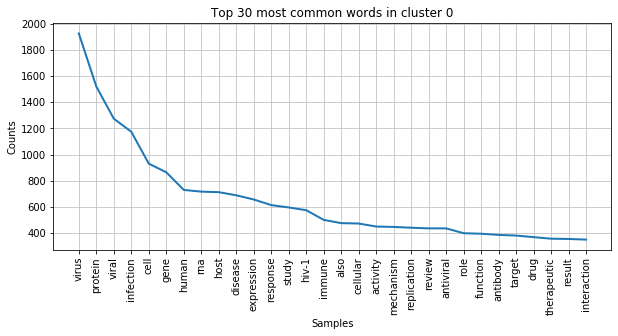

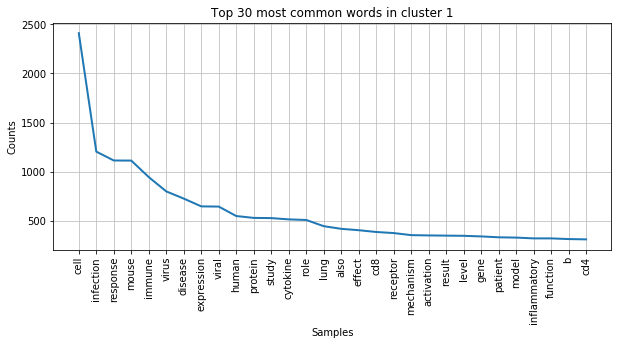

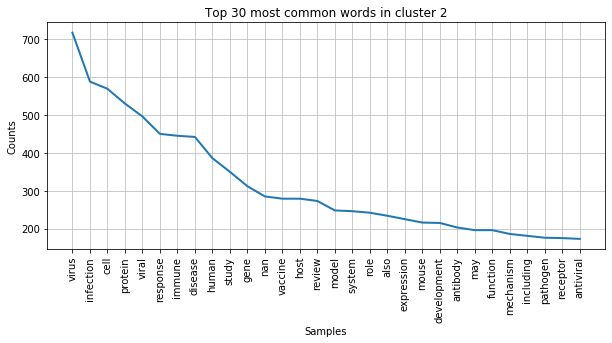

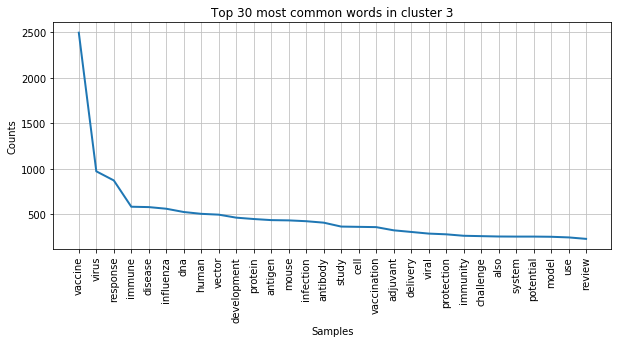

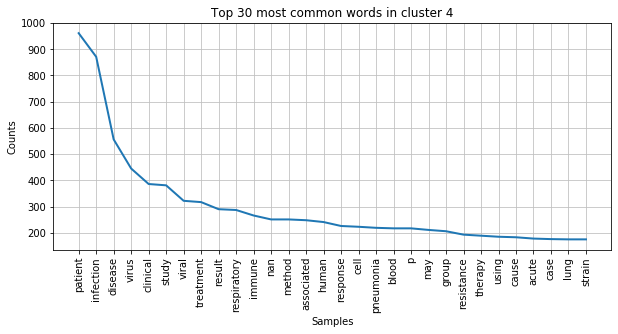

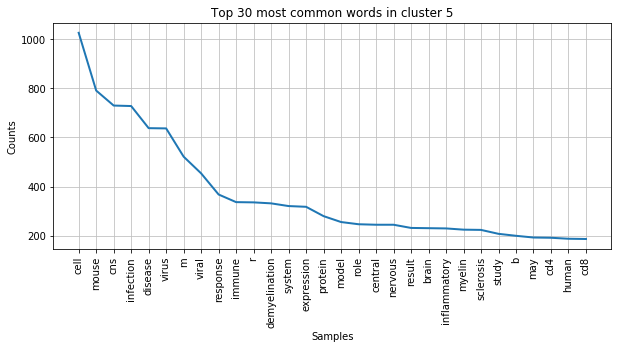

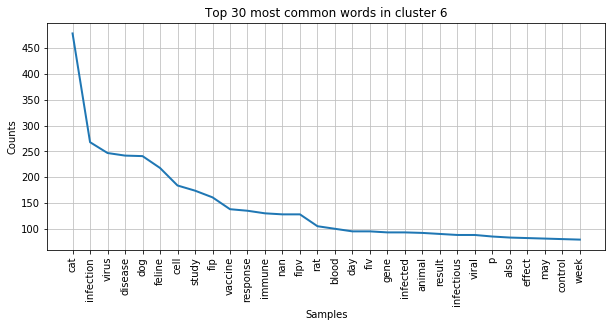

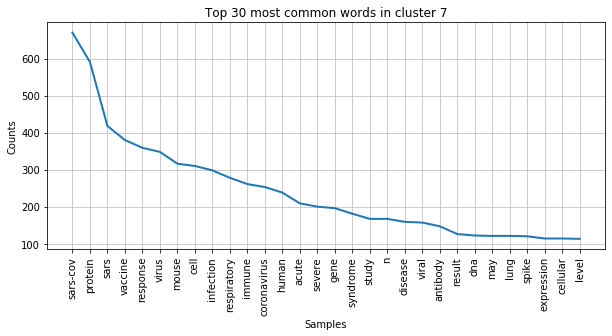

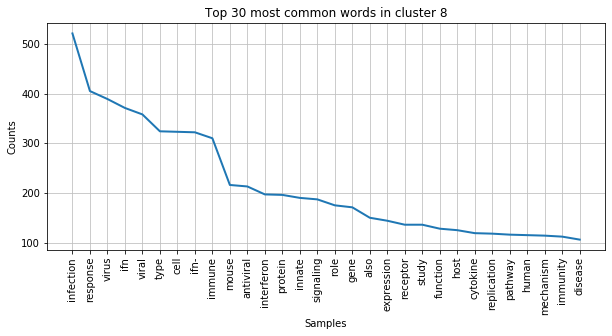

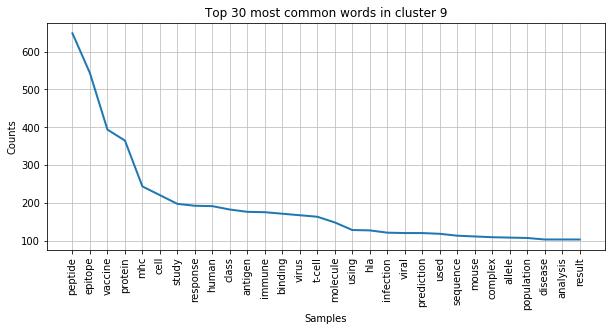

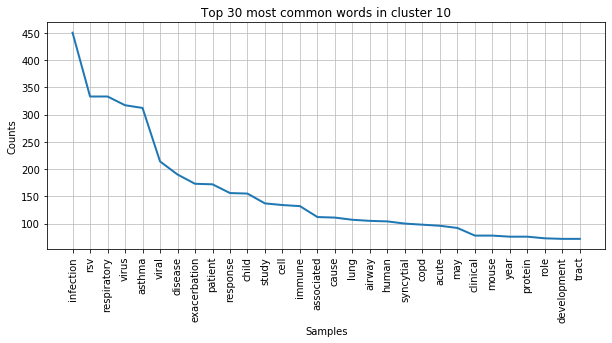

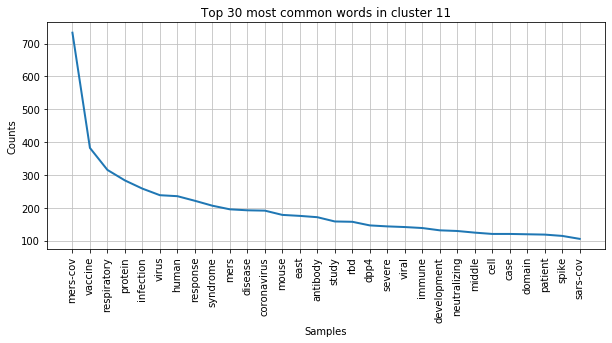

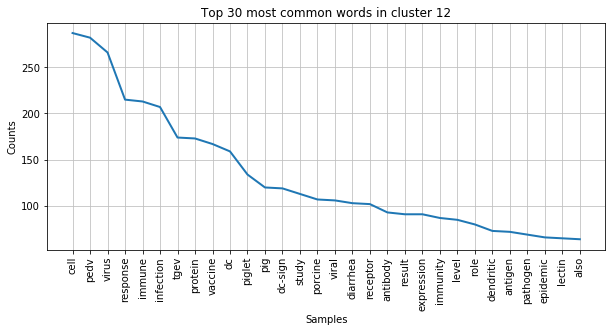

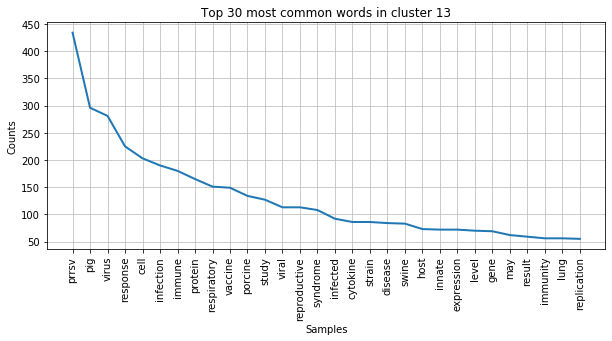

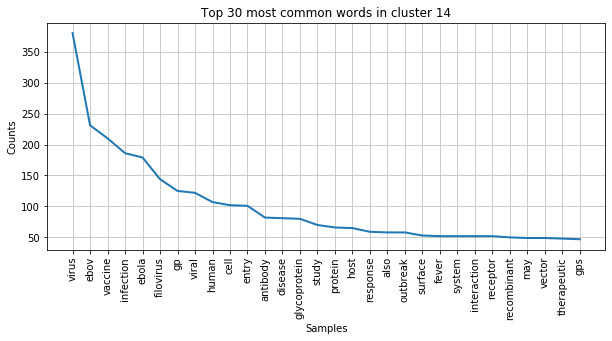

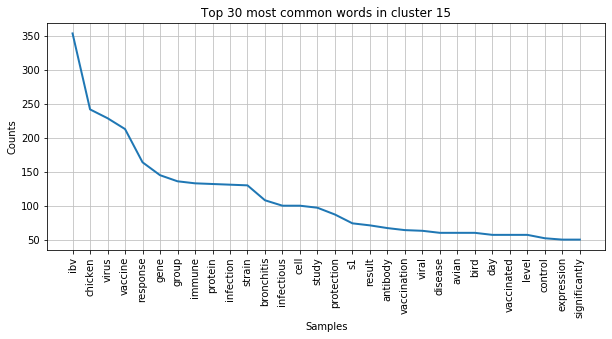

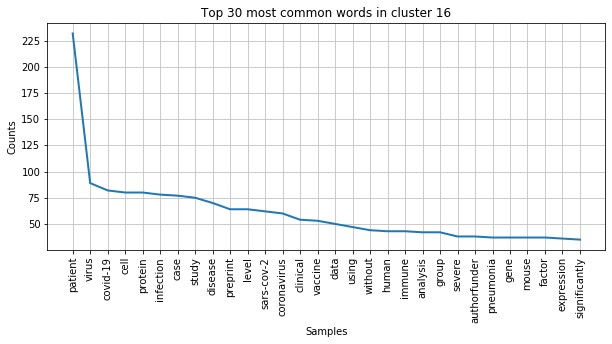

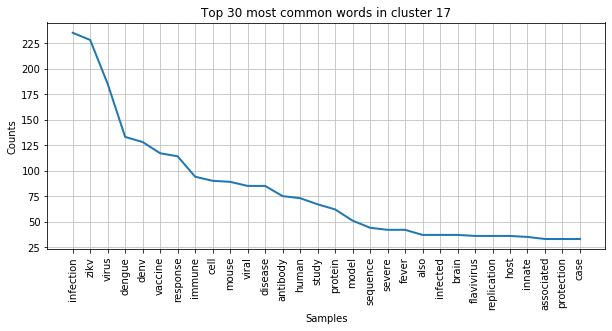

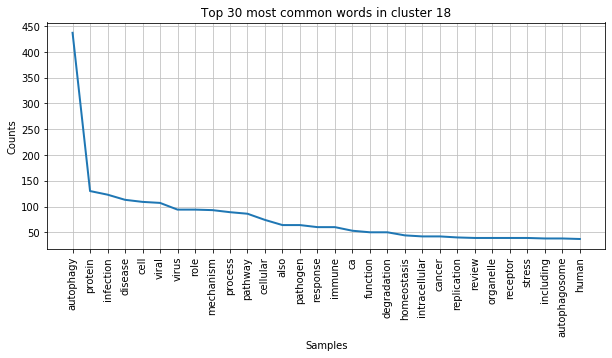

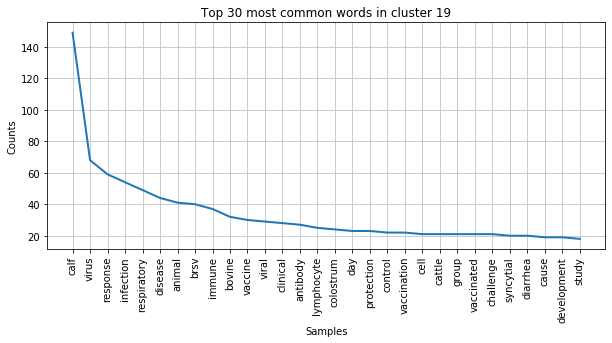

In [4]:
# Identify keywords in texts for each cluster
# Make folder to save plots
pathc = patht + "/cluster_topic_plots"
try:
    # Create target Directory
    os.mkdir(pathc)
    print("Directory " , pathc ,  " Created ") 
except FileExistsError:
    print("Directory " , pathc ,  " already exists")

# Make folder to save cluster dataframes
pathcdf = patht + "/cluster_topic_dataframes"
try:
    # Create target Directory
    os.mkdir(pathcdf)
    print("Directory " , pathcdf ,  " Created ") 
except FileExistsError:
    print("Directory " , pathcdf ,  " already exists")

#####----------------------------------#######################----------------------------------########
# Some options Options
# Which clusters do you want to plot Louvain clusters = l or k-means clusters = k
c_choice = 'l'

# Which lexicon normalization mode do you want to use Stemming = stm or Lemmatization = lem
ln_choice = "lem"
#####----------------------------------#######################----------------------------------########

# Import stop words
stop_words=set(stopwords.words("english"))
stop_words.update(["et", "al.", ".", "'", ",", "[", "]", "fig", "figure", "cell"])

# Tokenize the text and plot fre dist plots
if c_choice == 'l':  
    for c in (sorted(plt_data["l_clusters"].unique())):
        #print(c)
        c_df = plt_data[plt_data.l_clusters == c]
        small_df = c_df[["paper_id", "title"]]
        small_df.to_csv(pathcdf + "/papers in louvian cluster {}.csv".format(c), index = False)
        # Filter the text
        text = c_df["abstract"].str.split('\n')
        vals = ','.join(str(x) for x in text)
        tokenized_word=word_tokenize(vals)
        filtered_sent=[]
        for w in tokenized_word:
            if w not in stop_words:
                filtered_sent.append(w)
        root_words=[]
        lem = WordNetLemmatizer()
        ps = PorterStemmer()        
        if ln_choice == "stm":
            for w in filtered_sent:
                root_words.append(ps.stem(w))
        if ln_choice == "lem":
            for w in filtered_sent:
                root_words.append(lem.lemmatize(w))
        # Remove integers only
        no_integers = [x for x in root_words if not (x.isdigit()  or x[0] == '-' and x[1:].isdigit())]            
        # Frequency dstribution of words in text and plotting data
        fdist = FreqDist(no_integers)
        fig = plt.figure(figsize = (10,5))
        plt.gcf().subplots_adjust(bottom=0.25) # to avoid x-ticks cut-off
        fdist.plot(30,cumulative=False, title = "Top 30 most common words in cluster {}".format(c))
        plt.show()
        fig.savefig(pathc + "/Most common words in louvain cluster {}_{}_lexicon.png".format(c, ln_choice))

# Tokenize the text and plot fre dist plots
if c_choice == 'k':  
    for c in (sorted(plt_data["l_clusters"].unique())):
        c_df = plt_data[plt_data.k_clusters == c]
        small_df = c_df[["paper_id", "title"]]
        small_df.to_csv(pathcdf + "/papers in k-means cluster {}.csv".format(c), index = False)
        # Filter the text
        text = c_df["abstract"].str.split('\n')
        vals = ','.join(str(x) for x in text)
        tokenized_word=word_tokenize(vals)
        filtered_sent=[]
        for w in tokenized_word:
            if w not in stop_words:
                filtered_sent.append(w)
        root_words=[]
        lem = WordNetLemmatizer()
        ps = PorterStemmer()        
        if ln_choice == "stm":
            for w in filtered_sent:
                root_words.append(ps.stem(w))
        if ln_choice == "lem":
            for w in filtered_sent:
                root_words.append(lem.lemmatize(w))
        # Remove integers only
        no_integers = [x for x in root_words if not (x.isdigit()  or x[0] == '-' and x[1:].isdigit())]            
        # Frequency dstribution of words in text and plotting data
        fdist = FreqDist(no_integers)
        fig = plt.figure(figsize = (10,5))
        plt.gcf().subplots_adjust(bottom=0.25) # to avoid x-ticks cut-off
        fdist.plot(30,cumulative=False, title = "Top 30 most common words in cluster {}".format(c))
        plt.show()
        fig.savefig(pathc + "/Most common words in k-means cluster {}_{}_lexicon.pdf".format(c, ln_choice))
